## Correlation Matrix of Connectivity Models
- How connectivity models are correlated with each other
- If we have the corr matrix, and integration weights (avg and bayes), what would be the correlation between group models?
- Do they differ enough to make a difference?

In [1]:
import init_paths
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [2]:
def calc_coef_corr(train_types):
    all_fitted_models = []
    all_train_infos = []
    for dataset_name, (train_ses, eval_ses, la) in train_types.items():
        config = rm.get_eval_config(eval_dataset=dataset_name, eval_ses=eval_ses, model='ind', cerebellum='MNISymC3', add_rest=True)
        dataset = fdata.get_dataset_class(gl.base_dir, dataset=dataset_name)
        config["subj_list"] = dataset.get_participants().participant_id

        dirname=[]
        mname=[]
        for a in la:
            dirname.append(f"{dataset_name}_CondHalf_{train_ses}_run-all_Icosahedron1002_L2reg")
            mname.append(f"{dataset_name}_CondHalf_{train_ses}_run-all_Icosahedron1002_L2reg_A{a}")

        fm,ti = rm.get_fitted_models(dirname,mname,config)
        all_fitted_models.extend(fm[0])
        all_train_infos.extend(ti[0])
    
    sim_df = pd.DataFrame(columns=['dataset_i', 'subj_i', 'dataset_j', 'subj_j', 'cov', 'corr'])
    N = len(all_fitted_models)
    for i in range(N):
        for j in range(i, N):
            pair_corr = np.corrcoef(all_fitted_models[i].coef_.flatten(), all_fitted_models[j].coef_.flatten())[0,1]
            pair_cov = np.cov(all_fitted_models[i].coef_.flatten(), all_fitted_models[j].coef_.flatten())[0,1]
            new_row1 = {'dataset_i': all_train_infos[i]['train_dataset'],
                       'subj_i': all_train_infos[i]['subj_id'],
                       'dataset_j': all_train_infos[j]['train_dataset'],
                       'subj_j': all_train_infos[j]['subj_id'],
                       'cov': pair_cov,
                       'corr': pair_corr}
            sim_df.loc[len(sim_df)] = new_row1
            if i!=j:
                new_row2 = {'dataset_i': all_train_infos[j]['train_dataset'],
                        'subj_i': all_train_infos[j]['subj_id'],
                        'dataset_j': all_train_infos[i]['train_dataset'],
                        'subj_j': all_train_infos[i]['subj_id'],
                        'cov': pair_cov,
                        'corr': pair_corr}
                sim_df.loc[len(sim_df)] = new_row2
    return sim_df

In [3]:
dataset_list = ["MDTB", "WMFS", "Nishimoto"]
logalpha_list = [10]
train_types = {
    'MDTB':        ('ses-s1',     'ses-s2',      logalpha_list),
    'WMFS':        ('ses-01',     'ses-02',      logalpha_list),
    'Nishimoto':   ('ses-01',     'ses-02',      logalpha_list),
}

In [4]:
# Run this only if you haven't already
# sim_df = calc_coef_corr(train_types)
# sim_df.to_csv('/home/ROBARTS/ashahb7/Github/bayes_temp/sim_df.tsv', sep='\t', index=False)

# Or just load it if you have access
sim_df = pd.read_csv('/home/ROBARTS/ashahb7/Github/bayes_temp/sim_df.tsv', sep='\t')

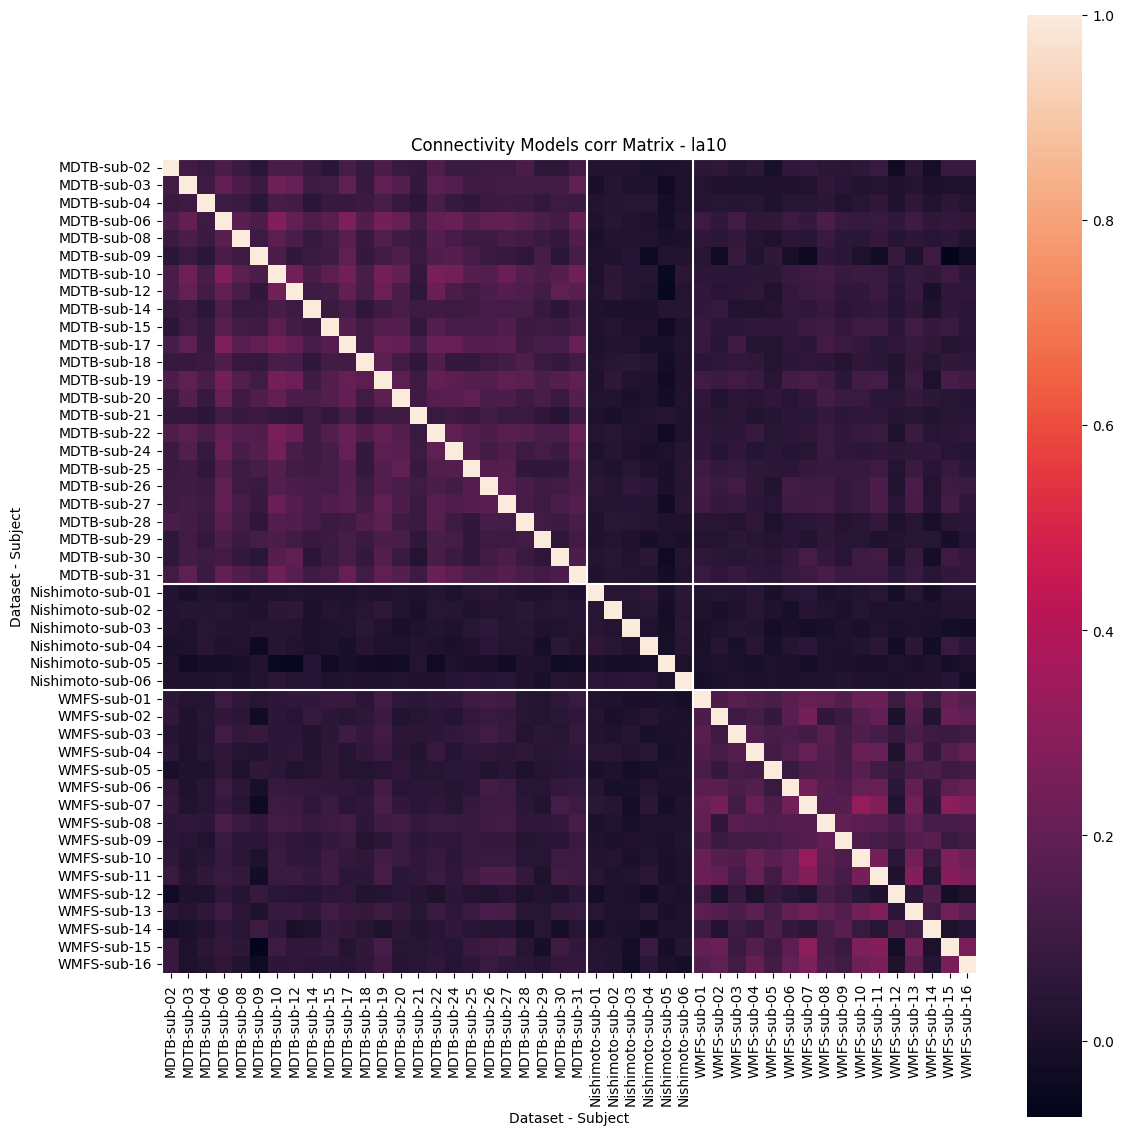

In [13]:
attribute_to_plot = "corr" # "corr" or "cov"
plt.figure(figsize=(12,12))
pivot_df = sim_df.pivot_table(index=['dataset_i', 'subj_i'], columns=['dataset_j', 'subj_j'], values=attribute_to_plot, aggfunc='mean')
corr_pivot_df = sim_df.pivot_table(index=['dataset_i', 'subj_i'], columns=['dataset_j', 'subj_j'], values="corr", aggfunc='mean')
cov_pivot_df = sim_df.pivot_table(index=['dataset_i', 'subj_i'], columns=['dataset_j', 'subj_j'], values="cov", aggfunc='mean')
sns.heatmap(pivot_df, square=True)

x_positions = [pivot_df.index.get_loc((dataset_j, sim_df[sim_df['dataset_j'] == dataset_j]['subj_j'].unique()[0])) for dataset_j in sim_df.dataset_j.unique()]
y_positions = [pivot_df.index.get_loc((dataset_i, sim_df[sim_df['dataset_i'] == dataset_i]['subj_i'].unique()[0])) for dataset_i in sim_df.dataset_i.unique()]
for posv in x_positions:
    plt.axvline(x=posv, linewidth=1.5, color='white')
for posh in y_positions:
    plt.axhline(y=posh, linewidth=1.5, color='white')

plt.title(f'Connectivity Models {attribute_to_plot} Matrix - la{str(logalpha_list[0])}')
plt.xlabel('Dataset - Subject')
plt.ylabel('Dataset - Subject')
plt.tight_layout()

### Correlation Between Two Weighted Group Models

Let ($m_1, m_2, \dots, m_N$) be individual connectivity models. For any pair of models ($m_i$) and ($m_j$), the covariance is given by:

$$
\operatorname{Cov}(m_i, m_j) = C_{ij},
$$
where \( $C$ \) is the covariance matrix, and each element ($C_{ij}$) can also be expressed as:
$$
C_{ij} = R_{ij} \sigma_i \sigma_j,
$$
with \( $R_{ij}$ \) representing the correlation coefficient between \( $m_i$ \) and \( $m_j$ \), and \( $\sigma_i$, $\sigma_j$ \) being the standard deviations of \( $m_i$ \) and \( $m_j$ \), respectively.

We define two group models as weighted averages of the matrices:

- **Group 1 (simple average):**
  $$
  g_1 = \sum_{i=1}^{N} a_i m_i,
  $$
  where ( $\mathbf{a} = \left(\frac{1}{N}, \frac{1}{N}, \dots, \frac{1}{N}\right)^T$ ) represents the weights for the simple average model.

- **Group 2 (Bayesian weighted average):**
  $$
  g_2 = \sum_{i=1}^{N} b_i m_i,
  $$
  where \( $\mathbf{b} = \left(w_1, w_2, \dots, w_N\right)^T$ \) represents the Bayesian weights.

### Variance of \( $g_1$ \) and \( $g_2$ \)
The variances of \( $g_1$ \) and \( $g_2$ \) can be computed using the quadratic forms:
$$
\operatorname{Var}(g_1) = \mathbf{a}^T C \mathbf{a}, \quad \operatorname{Var}(g_2) = \mathbf{b}^T C \mathbf{b}.
$$

### Covariance Between \( $g_1$ \) and \( $g_2$ \)
The covariance between the two group models is:
$$
\operatorname{Cov}(g_1, g_2) = \mathbf{a}^T C \mathbf{b}.
$$

### Correlation Between \( $g_1$ \) and \( $g_2$ \)
Finally, the correlation coefficient between \( $g_1$ \) and \( $g_2$ \) is:
$$
\rho(g_1, g_2) = \frac{\mathbf{a}^T C \mathbf{b}}{\sqrt{(\mathbf{a}^T C \mathbf{a}) (\mathbf{b}^T C \mathbf{b})}}.
$$

In [7]:
var_df = pd.read_csv('/home/ROBARTS/ashahb7/Github/bayes_temp/var_df.tsv', sep='\t')
var_df = var_df[var_df['logalpha']==logalpha_list[0]]

MDS stress: 0.29


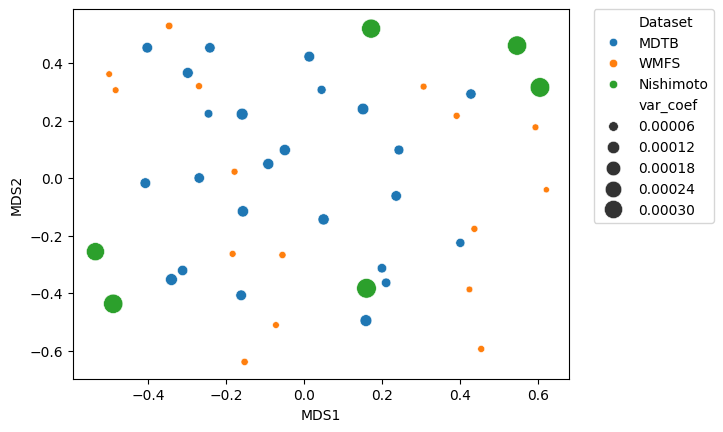

In [14]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, metric=False, normalized_stress=True)
mds_transformed = mds.fit_transform(1-corr_pivot_df.values)
print(f'MDS stress: {mds.stress_:.2f}')
mds_df = pd.DataFrame(mds_transformed, columns=['MDS1', 'MDS2'])
mds_df['Dataset'] = [idx[0] for idx in corr_pivot_df.index]
mds_df['var_coef'] = var_df.pivot_table(index=['train_dataset', 'subj_id'], values='coef_var').values

sns.scatterplot(data=mds_df, x='MDS1', y='MDS2', hue='Dataset', hue_order=dataset_list, size='var_coef', sizes=(20,200))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [15]:
for dataset_name, (_, _, _) in train_types.items():
    print(f'\nDataset: {dataset_name}')
    dataset_sim_subset = sim_df[(sim_df['dataset_i']==dataset_name) & (sim_df['dataset_j']==dataset_name)]
    dataset_var_subset = var_df[var_df['train_dataset']==dataset_name]
    pivot_dataset_sim_subset = dataset_sim_subset.pivot_table(index=['dataset_i', 'subj_i'], columns=['dataset_j', 'subj_j'], values='cov')
    pivot_dataset_var_df = dataset_var_subset.pivot_table(index=['train_dataset', 'subj_id'], values='coef_var')

    num_subj = pivot_dataset_sim_subset.shape[0]
    C = np.array(pivot_dataset_sim_subset.values)
    loo_weights = np.full((num_subj,1), 1/num_subj)
    bayes_weights = np.array(pivot_dataset_var_df.values)
    bayes_weights /= bayes_weights.sum()

    var_loo = loo_weights.T @ C @ loo_weights
    var_bayes = bayes_weights.T @ C @ bayes_weights
    cov_loo_bayes = loo_weights.T @ C @ bayes_weights
    # print(f'loo-bayes cov: {cov_loo_bayes}')
    corr_loo_bayes = cov_loo_bayes / np.sqrt(var_loo * var_bayes)
    print(f'loo-bayes corr: {np.squeeze(corr_loo_bayes):.3f}')


Dataset: MDTB
loo-bayes corr: 0.993

Dataset: WMFS
loo-bayes corr: 0.990

Dataset: Nishimoto
loo-bayes corr: 0.999


In [16]:
pivot_sim_df = sim_df.pivot_table(index=['dataset_i', 'subj_i'], columns=['dataset_j', 'subj_j'], values='cov')
pivot_var_df = var_df.pivot_table(index=['train_dataset', 'subj_id'], values='coef_var')

C = np.array(pivot_sim_df.values)
loo_weights = np.full((len(pivot_sim_df),1), 1/len(pivot_sim_df))
bayes_weights = np.array(pivot_var_df.values)
bayes_weights /= bayes_weights.sum()

var_loo = loo_weights.T @ C @ loo_weights
var_bayes = bayes_weights.T @ C @ bayes_weights
cov_loo_bayes = loo_weights.T @ C @ bayes_weights
# print(f'loo-bayes cov: {cov_loo_bayes}')
corr_loo_bayes = cov_loo_bayes / np.sqrt(var_loo * var_bayes)
print('Across all datasets:')
print(f'loo-bayes corr: {np.squeeze(corr_loo_bayes):.3f}')

Across all datasets:
loo-bayes corr: 0.794
